#Leveraging Ensemble Adversarial Training to Build More Robust PDF Malware Classifiers

---
The goal of the study is to contribute to building more robust PDF malware classifiers by relying on Adversarial Training. For this reason, we propose 3 architectures that can help in the process.


### Cloning the Github Repo

In [2]:
!git clone https://github.com/fouadtrad/Leveraging-Adversarial-Samples-for-Enhanced-Classification-of-Malicious-and-Evasive-PDF-Files

Cloning into 'Leveraging-Adversarial-Samples-for-Enhanced-Classification-of-Malicious-and-Evasive-PDF-Files'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 21 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), 26.08 MiB | 4.75 MiB/s, done.


In [4]:
!unzip "/content/Leveraging-Adversarial-Samples-for-Enhanced-Classification-of-Malicious-and-Evasive-PDF-Files/Training Data.zip"
!unzip "/content/Leveraging-Adversarial-Samples-for-Enhanced-Classification-of-Malicious-and-Evasive-PDF-Files/University_Testing_data.zip"

Archive:  /content/Leveraging-Adversarial-Samples-for-Enhanced-Classification-of-Malicious-and-Evasive-PDF-Files/Training Data.zip
replace evasive.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: evasive.csv             
  inflating: non_evasive.csv         
Archive:  /content/Leveraging-Adversarial-Samples-for-Enhanced-Classification-of-Malicious-and-Evasive-PDF-Files/University_Testing_data.zip
  inflating: classifier_university_1.csv  


## Importing the libraries

In [6]:
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, multilabel_confusion_matrix
import seaborn as sns

##Define Helper Functions

In [28]:
def get_metrics(model, x, y, label='Malware'):
  
  y_true = y
  pred = model.predict(x)
  acc = accuracy_score(y_true, pred)
  prec = precision_score(y_true, pred)
  rec = recall_score(y_true, pred)
  f1 = f1_score(y_true, pred)

  print(acc, prec, rec, f1)

  pred = np.where(pred < 0.5, 0, 1)

  confusion = confusion_matrix(y_true, pred, normalize='true')
  
  pred_labels = [f'pred_not_{label}', f'pred_{label}']
  real_labels = [f'real_not_{label}', f'real_{label}']
  #sns.set(font_scale=1.3)
  plt.figure()
  sns.heatmap(confusion, annot=True,fmt=".2%", xticklabels = pred_labels, yticklabels = real_labels )


In [8]:
def print_confusion_matrix(confusion, label='Malware'):

  pred_labels = [f'pred_not_{label}', f'pred_{label}']
  real_labels = [f'real_not_{label}', f'real_{label}']
  #sns.set(font_scale=1.3)
  sns.heatmap(confusion, annot=True,fmt=".2%",xticklabels = pred_labels, yticklabels = real_labels)

##Importing the datasets

The datasets we will be using fall under 2 categories: Evasive and Non-Evasive. The sources of these datasets are varied, and the way we combined these datasets can be found in another notebook.

In [9]:
evasive = pd.read_csv('/content/evasive.csv')
non_evasive = pd.read_csv('/content/non_evasive.csv')

print(f"We have {len(evasive)} evasive samples and {len(non_evasive)} non evasive samples")

We have 20059 evasive samples and 20647 non evasive samples


The first thing we do, is to remove the duplicates across the dataframes.

In [10]:
evasive=evasive.drop_duplicates()
non_evasive=non_evasive.drop_duplicates()

print(len(evasive), len(non_evasive))

20059 20647


We examine the distribution of our labels for evasive and non evasive samples.

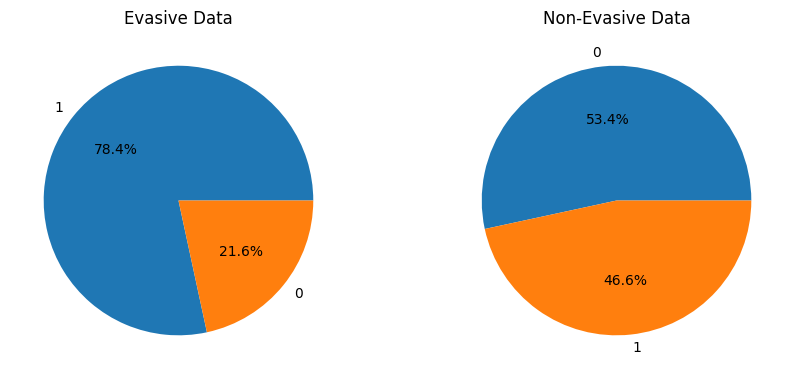

In [19]:
evasive_value_counts = evasive['class'].value_counts()
evasive_labels = evasive_value_counts.index
evasive_sizes = evasive_value_counts.values

non_evasive_value_counts = non_evasive['class'].value_counts()
non_evasive_labels = non_evasive_value_counts.index
non_evasive_sizes = non_evasive_value_counts.values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.pie(evasive_sizes, labels=evasive_labels, autopct='%1.1f%%')
ax1.set_title('Evasive Data')
ax1.set_aspect('equal')

ax2.pie(non_evasive_sizes, labels=non_evasive_labels, autopct='%1.1f%%')
ax2.set_title('Non-Evasive Data')
ax2.set_aspect('equal')

plt.subplots_adjust(wspace=0.3)

plt.show()


We merge the 2 dataframes

In [20]:
df= pd.concat([evasive, non_evasive], axis=0)
len(df)

40706

In [21]:
df['class'].value_counts()

1    25347
0    15359
Name: class, dtype: int64

To do differentiate between the 2 datasets, we add a column named "Evasive", and we set it to 0 or 1 accordingly.

In [22]:
evasive['Evasive'] = 1
non_evasive['Evasive'] = 0

Getting the features and the targets for each dataset

In [23]:
x_n_e = non_evasive.iloc[:,:-2]
y_n_e = non_evasive.iloc[:,-2:]

x_e = evasive.iloc[:,:-2]
y_e = evasive.iloc[:,-2:]

Leaving from both sets 20% for final testing to see how well the model generalizes.

In [24]:
from sklearn.model_selection import train_test_split

x_n_e_train, x_n_e_test, y_n_e_train, y_n_e_test = train_test_split(x_n_e, y_n_e, random_state = 2, stratify = y_n_e.iloc[:,0], test_size=0.2)
x_e_train, x_e_test, y_e_train, y_e_test = train_test_split(x_e, y_e, random_state = 2, stratify = y_e.iloc[:,0], test_size=0.2)

In [25]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_n_e = StandardScaler()
scaler_n_e.fit(x_n_e_train)

StandardScaler()

In [26]:
scaler_e = StandardScaler()
scaler_e.fit(x_e_train)

StandardScaler()

##Building the base model

The first thing we do is to build a base model that detects malware, trained on non-evasive samples.

In [27]:
from sklearn.model_selection import cross_validate, GridSearchCV
from lightgbm import LGBMClassifier

###Model Selection to Build the Baseline

####Logistic Regression

0.9443099273607748 0.9136163982430454 0.9724675324675325 0.9421238047307499


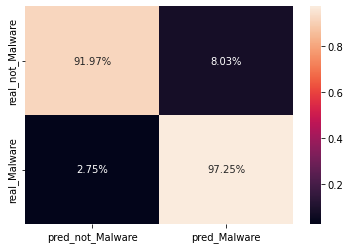

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(scaler_n_e.transform(x_n_e_train), y_n_e_train.iloc[:,0])
get_metrics(lr, scaler_n_e.transform(x_n_e_test), y_n_e_test.iloc[:,0])

####SVM with RBF kernel


0.987409200968523 0.9880145909327774 0.9849350649350649 0.9864724245577523


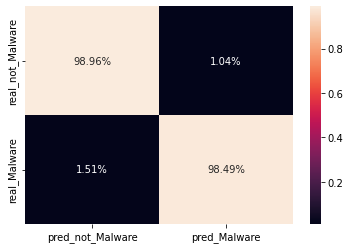

In [ ]:
from sklearn.svm import SVC

svc_rbf = SVC()
svc_rbf.fit(scaler_n_e.transform(x_n_e_train), y_n_e_train.iloc[:,0])
get_metrics(svc_rbf, scaler_n_e.transform(x_n_e_test), y_n_e_test.iloc[:,0])

####SVM with Polynomial Kernel

0.9232445520581114 0.8785310734463276 0.9693506493506493 0.9217090639664113


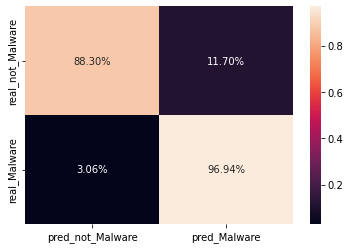

In [ ]:
from sklearn.svm import SVC

svc_poly_1 = SVC(kernel = "poly", degree=1)
svc_poly_1.fit(scaler_n_e.transform(x_n_e_train), y_n_e_train.iloc[:,0])
get_metrics(svc_poly_1, scaler_n_e.transform(x_n_e_test), y_n_e_test.iloc[:,0])

0.9602905569007264 0.9417962870045158 0.9750649350649351 0.958141909137315


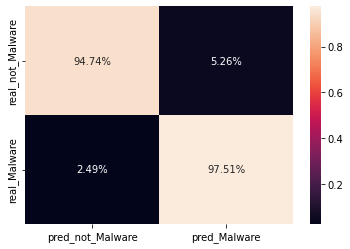

In [ ]:
from sklearn.svm import SVC

svc_poly_2 = SVC(kernel = "poly", degree=2)
svc_poly_2.fit(scaler_n_e.transform(x_n_e_train), y_n_e_train.iloc[:,0])
get_metrics(svc_poly_2, scaler_n_e.transform(x_n_e_test), y_n_e_test.iloc[:,0])

0.7784503631961259 0.9557761732851986 0.5501298701298701 0.6983184965380811


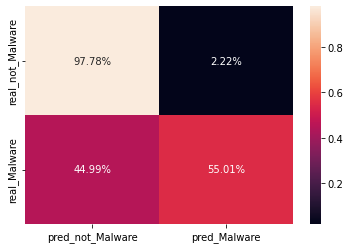

In [ ]:
from sklearn.svm import SVC

svc_poly = SVC(kernel = "poly", degree=3)
svc_poly.fit(scaler_n_e.transform(x_n_e_train), y_n_e_train.iloc[:,0])
get_metrics(svc_poly, scaler_n_e.transform(x_n_e_test), y_n_e_test.iloc[:,0])

####Naive Bayes

0.8280871670702179 0.7845433255269321 0.8701298701298701 0.8251231527093595


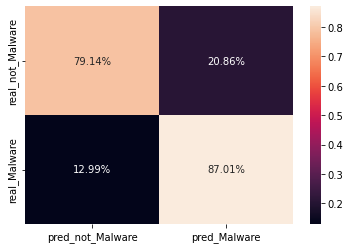

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(x_n_e_train, y_n_e_train.iloc[:,0])
get_metrics(nb, x_n_e_test, y_n_e_test.iloc[:,0])

####Random Forest Classifier

0.9970944309927361 0.9994778067885117 0.9942857142857143 0.9968750000000001


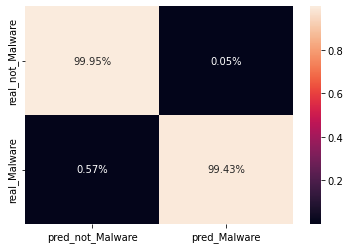

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_n_e_train, y_n_e_train.iloc[:,0])
get_metrics(rf, x_n_e_test, y_n_e_test.iloc[:,0])

####Adaboost Classifier

0.9932203389830508 0.9947835159102765 0.9906493506493507 0.9927121290994274


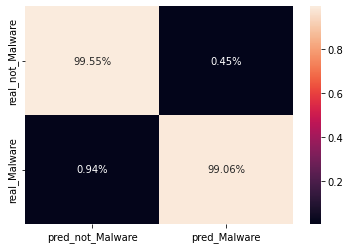

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier()
ab.fit(x_n_e_train, y_n_e_train.iloc[:,0])
get_metrics(ab, x_n_e_test, y_n_e_test.iloc[:,0])

#### LightGBM Classifier

0.9932203389830508 0.9947835159102765 0.9906493506493507 0.9927121290994274


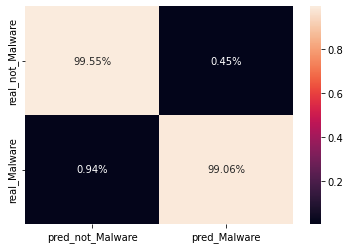

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()
lgbm.fit(x_n_e_train, y_n_e_train.iloc[:,0])
get_metrics(ab, x_n_e_test, y_n_e_test.iloc[:,0])

####Testing these Models on evasive data

<class 'sklearn.linear_model._logistic.LogisticRegression'>
0.3773678963110668 0.8290946083418108 0.2591414944356121 0.39486434108527135
<class 'sklearn.svm._classes.SVC'>
0.4499002991026919 0.9342592592592592 0.32082670906200317 0.4776331360946745
<class 'sklearn.svm._classes.SVC'>
0.38534396809571286 0.8398398398398398 0.2667726550079491 0.4049227799227799
<class 'sklearn.svm._classes.SVC'>
0.3915752741774676 0.8801295896328294 0.2591414944356121 0.40039302382706954


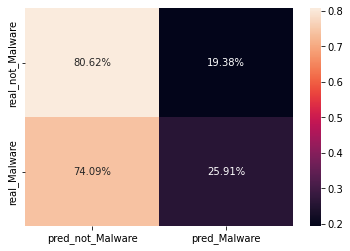

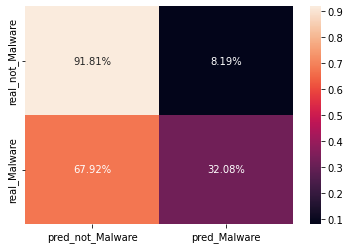

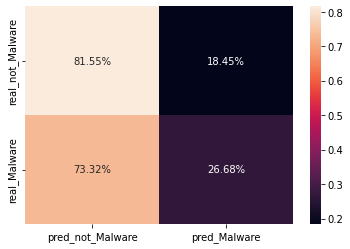

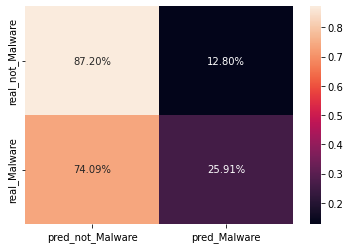

In [ ]:
models = [lr,svc_rbf,svc_poly_1, svc_poly_2]

for non_evasive_model in models:
  print(type(non_evasive_model))
  get_metrics(non_evasive_model, scaler_n_e.transform(x_e_test), y_e_test.iloc[:,0])

<class 'sklearn.naive_bayes.MultinomialNB'>
0.344715852442672 0.8623595505617978 0.19523052464228935 0.3183821623023075
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
0.3983050847457627 0.9752925877763329 0.2384737678855326 0.38323965252938175
<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
0.39955134596211367 0.9433734939759036 0.24896661367249603 0.3939622641509434
<class 'lightgbm.sklearn.LGBMClassifier'>
0.6627617148554337 0.9691099476439791 0.5885532591414945 0.7323442136498518


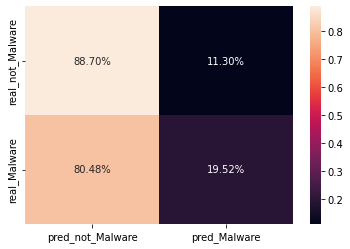

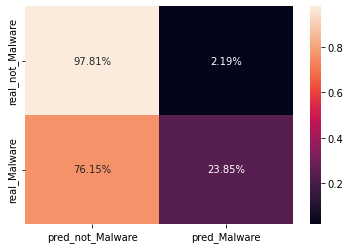

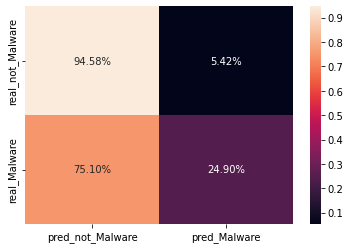

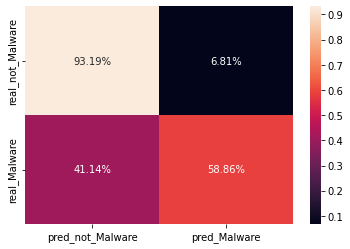

In [ ]:
models = [nb, rf, ab, lgbm]
for non_evasive_model in models:
  print(type(non_evasive_model))
  get_metrics(non_evasive_model, x_e_test, y_e_test.iloc[:,0])

####Fine tuning the LGBM

In [ ]:
non_evasive_model = LGBMClassifier(n_estimators = 500)

grid_params = {
    'max_depth' : [5,7,10],
    'max_leaf_nodes' : [2,5,7]
}

grid = GridSearchCV(non_evasive_model, grid_params, scoring=['accuracy', 'precision', 'recall', 'f1'], cv=5, refit = 'f1', verbose=2)
grid.fit(x_n_e_train, y_n_e_train.iloc[:,0])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ......................max_depth=5, max_leaf_nodes=2; total time=   1.1s
[CV] END ......................max_depth=5, max_leaf_nodes=2; total time=   1.1s
[CV] END ......................max_depth=5, max_leaf_nodes=2; total time=   1.1s
[CV] END ......................max_depth=5, max_leaf_nodes=2; total time=   1.2s
[CV] END ......................max_depth=5, max_leaf_nodes=2; total time=   1.1s
[CV] END ......................max_depth=5, max_leaf_nodes=5; total time=   1.1s
[CV] END ......................max_depth=5, max_leaf_nodes=5; total time=   1.1s
[CV] END ......................max_depth=5, max_leaf_nodes=5; total time=   1.1s
[CV] END ......................max_depth=5, max_leaf_nodes=5; total time=   1.1s
[CV] END ......................max_depth=5, max_leaf_nodes=5; total time=   1.1s
[CV] END ......................max_depth=5, max_leaf_nodes=7; total time=   1.1s
[CV] END ......................max_depth=5, max_l

GridSearchCV(cv=5, estimator=LGBMClassifier(n_estimators=500),
             param_grid={'max_depth': [5, 7, 10], 'max_leaf_nodes': [2, 5, 7]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'],
             verbose=2)

In [ ]:
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 10, 'max_leaf_nodes': 2}
0.996877625270125


###Fit a model on the best parameters

In [ ]:
non_evasive_model = LGBMClassifier(n_estimators=500, max_depth=10, max_leaf_nodes=2)
non_evasive_model.fit(x_n_e_train, y_n_e_train.iloc[:,0])

LGBMClassifier(max_depth=10, max_leaf_nodes=2, n_estimators=500)

0.9968523002421308 0.9979166666666667 0.9953246753246753 0.9966189856957086


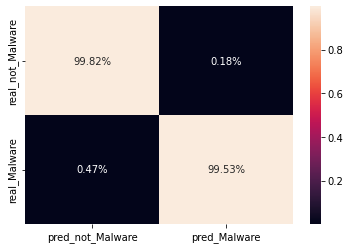

In [ ]:
get_metrics(non_evasive_model, x_n_e_test, y_n_e_test.iloc[:,0])

In [ ]:
import pickle
filename = 'LGBM_non_evasive_model.sav'
pickle.dump(non_evasive_model, open(filename, 'wb'))

## Build evasive only model

In [ ]:
evasive_model = LGBMClassifier(n_estimators=500, max_depth=10, max_leaf_nodes=2)
evasive_model.fit(x_e_train, y_e_train.iloc[:,0])

LGBMClassifier(max_depth=10, max_leaf_nodes=2, n_estimators=500)

0.9945164506480558 0.9980861244019139 0.9949125596184419 0.9964968152866241


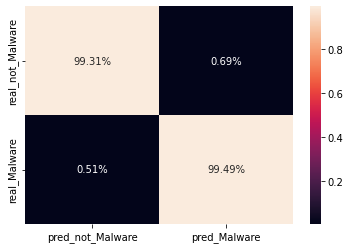

In [ ]:
get_metrics(evasive_model, x_e_test, y_e_test.iloc[:,0])

##Test the Baseline Model on Validation Evasive Data

0.6535393818544367 0.9740680713128039 0.5732909379968204 0.7217774219375501


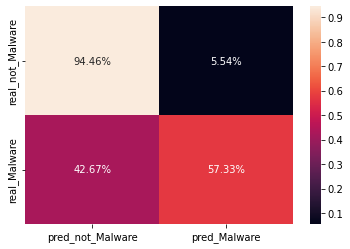

In [ ]:
get_metrics(non_evasive_model, x_e_test, y_e_test.iloc[:,0])

We see that the performance drops significantly.

##Building Robust Models

In [ ]:
x_n_e_train, x_n_e_test, y_n_e_train, y_n_e_test = train_test_split(x_n_e, y_n_e, random_state = 2, stratify = y_n_e.iloc[:,0], test_size=0.2)
x_e_train, x_e_test, y_e_train, y_e_test = train_test_split(x_e, y_e, random_state = 2, stratify = y_e.iloc[:,0], test_size=0.2)

In [ ]:
x_adv_train = pd.concat([x_n_e_train, x_e_train])
x_adv_test = pd.concat([x_n_e_test, x_e_test])
y_adv_train = pd.concat([y_n_e_train, y_e_train])
y_adv_test = pd.concat([y_n_e_test, y_e_test])

In [ ]:
scaler_adv = MinMaxScaler().fit(x_adv_train)

Evaluating the baseline on the mix of evasive and non evasive data

0.827683615819209 0.9862105542296473 0.7335305719921105 0.8413075443954304


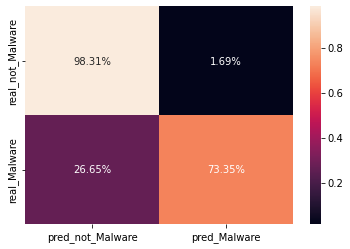

In [ ]:
get_metrics(non_evasive_model, x_adv_test, y_adv_test.iloc[:,0], label='Malware')

###Build Evasion Detection Model

###Trying multiple architectures

####Logistic Regression

0.7652910832719234 0.8962655601659751 0.5922233300099701 0.7131922557406574


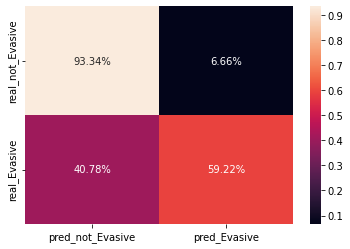

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(scaler_adv.transform(x_adv_train), y_adv_train.iloc[:,1])
get_metrics(lr, scaler_adv.transform(x_adv_test), y_adv_test.iloc[:,1], label='Evasive')

####SVM RBF

0.8059444853844264 0.9709527498063517 0.6248753738783649 0.7603882317258113


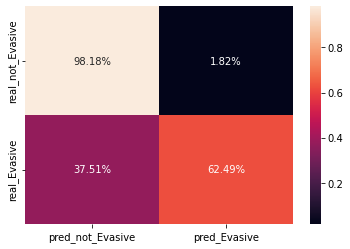

In [ ]:
from sklearn.svm import SVC

svm_rbf = SVC()
svm_rbf.fit(scaler_adv.transform(x_adv_train), y_adv_train.iloc[:,1])
get_metrics(svm_rbf, scaler_adv.transform(x_adv_test), y_adv_test.iloc[:,1], label='Evasive')

####SVM Poly

0.7711864406779662 0.9593843522873022 0.559322033898305 0.706660368445914


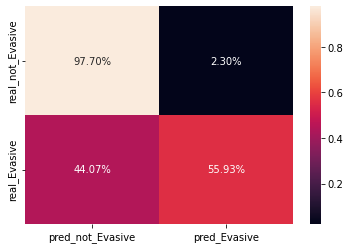

In [ ]:
from sklearn.svm import SVC

svm_poly = SVC(kernel="poly", degree=1)
svm_poly.fit(scaler_adv.transform(x_adv_train), y_adv_train.iloc[:,1])
get_metrics(svm_poly, scaler_adv.transform(x_adv_test), y_adv_test.iloc[:,1], label='Evasive')

0.7875214934905429 0.9492125984251969 0.6009471585244267 0.7359584859584859


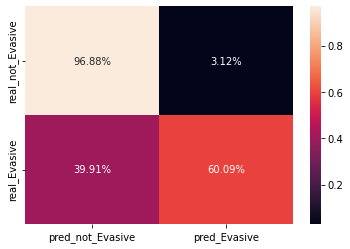

In [ ]:
from sklearn.svm import SVC

svm_poly = SVC(kernel="poly", degree=2)
svm_poly.fit(scaler_adv.transform(x_adv_train), y_adv_train.iloc[:,1])
get_metrics(svm_poly, scaler_adv.transform(x_adv_test), y_adv_test.iloc[:,1], label='Evasive')

0.7366740358634242 0.9814432989690721 0.4745762711864407 0.6397849462365591


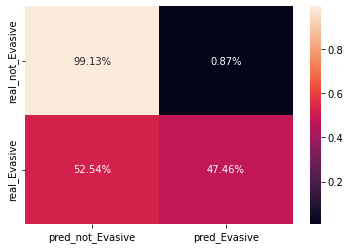

In [ ]:
from sklearn.svm import SVC

svm_poly = SVC(kernel="poly", degree=3)
svm_poly.fit(scaler_adv.transform(x_adv_train), y_adv_train.iloc[:,1])
get_metrics(svm_poly, scaler_adv.transform(x_adv_test), y_adv_test.iloc[:,1], label='Evasive')

####Naive Bayes

0.7397445345124048 0.787777439951353 0.6458125623130608 0.7097657855088345


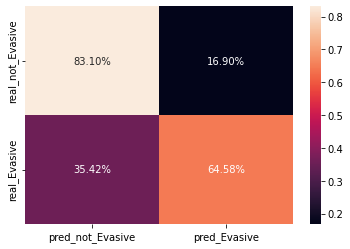

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(x_adv_train, y_adv_train.iloc[:,1])
get_metrics(nb, x_adv_test, y_adv_test.iloc[:,1], label='Evasive')

####Random Forest

0.9627855563743551 0.976857804062741 0.9469092721834497 0.9616504239969624


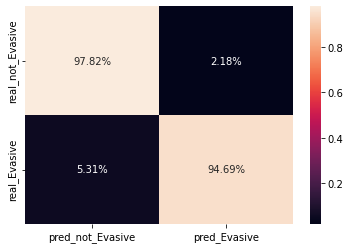

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_adv_train, y_adv_train.iloc[:,1])
get_metrics(rf, x_adv_test, y_adv_test.iloc[:,1], label='Evasive')

####Adaboost

0.8447555883075412 0.903169014084507 0.767198404785643 0.8296495956873314


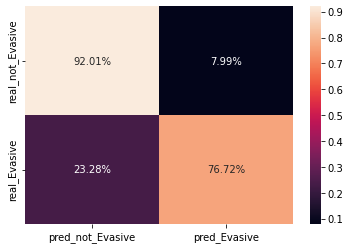

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier()
ab.fit(x_adv_train, y_adv_train.iloc[:,1])
get_metrics(ab, x_adv_test, y_adv_test.iloc[:,1], label='Evasive')

####LightGBM

0.9518545811839842 0.9763157894736842 0.9247258225324028 0.949820788530466


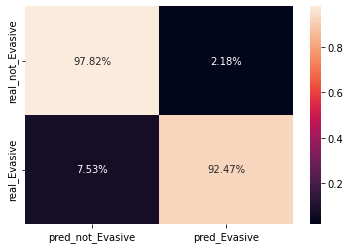

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()
lgbm.fit(x_adv_train, y_adv_train.iloc[:,1])
get_metrics(lgbm, x_adv_test, y_adv_test.iloc[:,1], label='Evasive')

Fine tuning the LightGBM

In [ ]:
ev_model = LGBMClassifier(max_depth = 10, max_leaf_nodes=2, n_estimators=500)
ev_model.fit(x_adv_train, y_adv_train.iloc[:,1])

LGBMClassifier(max_depth=10, max_leaf_nodes=2, n_estimators=500)

0.9684352738884795 0.9785878154473617 0.9568793619142573 0.9676118462507877


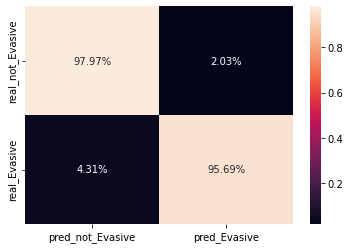

In [ ]:
get_metrics(ev_model, x_adv_test, y_adv_test.iloc[:,1], label='Evasive')

In [ ]:
import pickle
filename = 'LGBM_Evasion_detection_model.sav'
pickle.dump(ev_model, open(filename, 'wb'))

###**Approach 1:** Building Combined Adversarial Model

In [ ]:
from lightgbm import LGBMClassifier

adv_model = LGBMClassifier(n_estimators=500, max_depth=10, max_leaf_nodes=2)
adv_model.fit(x_adv_train, y_adv_train.iloc[:,0])

LGBMClassifier(max_depth=10, max_leaf_nodes=2, n_estimators=500)

####Aggregate Results

0.9948415622697127 0.9968379446640316 0.9948717948717949 0.9958538993089833


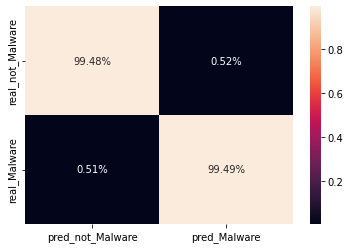

In [ ]:
get_metrics(adv_model, x_adv_test, y_adv_test.iloc[:,0])

####Evasive Only

0.9930209371884346 0.9971291866028709 0.9939586645468999 0.9955414012738854


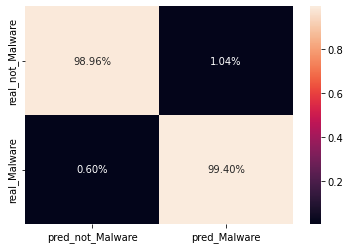

In [ ]:
get_metrics(adv_model, x_e_test, y_e_test.iloc[:,0])

###Beingn Only

0.9966101694915255 0.9963636363636363 0.9963636363636363 0.9963636363636363


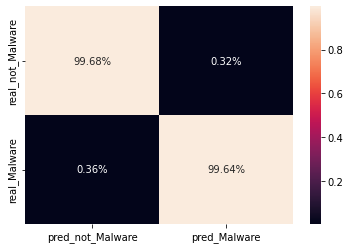

In [ ]:
get_metrics(adv_model, x_n_e_test, y_n_e_test.iloc[:,0])

In [ ]:
import pickle
filename = 'LGBM_Adv_model.sav'
pickle.dump(adv_model, open(filename, 'wb'))

###**Approach 2:** Separating Evasive and Non Evasive Models

In [ ]:
def predict(X):
  Y_pred = np.zeros((len(X),1))
  X=X.values
  pred = ev_model.predict(X)
  
  evasive_index = np.where(pred==1)
  non_ev_index = np.where(pred==0)
  
  if np.size(evasive_index[0])>0:

    ev_pred = evasive_model.predict(X[evasive_index[0],:])
    Y_pred[evasive_index] = np.expand_dims(ev_pred,-1)

  if np.size(non_ev_index[0])>0:
    non_ev_pred = non_evasive_model.predict(X[non_ev_index[0],:])
    Y_pred[non_ev_index] = np.expand_dims(non_ev_pred,-1)

  return Y_pred

In [ ]:
def predict_proba(X):
  Y_pred = np.zeros((len(X),1))
  X = X.values
  pred = ev_model.predict(X)
  
  evasive_index = np.where(pred==1)
  non_ev_index = np.where(pred==0)
  
  if np.size(evasive_index[0])>0:

    ev_pred = evasive_model.predict_proba(X[evasive_index[0],:])[:,1]
    Y_pred[evasive_index] = np.expand_dims(ev_pred,-1)

  if np.size(non_ev_index[0])>0:
    non_ev_pred = non_evasive_model.predict_proba(X[non_ev_index[0],:])[:,1]
    Y_pred[non_ev_index] = np.expand_dims(non_ev_pred,-1)

  return Y_pred

In [ ]:
x_adv_train = pd.concat([x_n_e_train, x_e_train])
x_adv_test = pd.concat([x_n_e_test, x_e_test])
y_adv_train = pd.concat([y_n_e_train, y_e_train])
y_adv_test = pd.concat([y_n_e_test, y_e_test])

In [ ]:
pred = predict(x_adv_test)

y_true = y_adv_test.iloc[:,0]

acc = accuracy_score(y_true, pred)
prec = precision_score(y_true, pred)
rec = recall_score(y_true, pred)
f1 = f1_score(y_true, pred)

print(acc, prec, rec, f1)

0.9943502824858758 0.9966389877421906 0.9942800788954635 0.9954581358609795


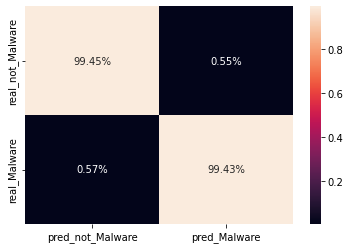

In [ ]:
pred = np.where(pred < 0.5, 0, 1)

confusion = confusion_matrix(y_true, pred, normalize='true')
print_confusion_matrix(confusion)

###**Approach 3:** One model, with several labels

In [ ]:
x_adv_train = pd.concat([x_n_e_train, x_e_train])
x_adv_test = pd.concat([x_n_e_test, x_e_test])
y_adv_train = pd.concat([y_n_e_train, y_e_train])
y_adv_test = pd.concat([y_n_e_test, y_e_test])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_adv_train = scaler.fit_transform(x_adv_train)
x_adv_test = scaler.transform(x_adv_test)

###Testing different architectures

####Logistic Regression

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


clf = MultiOutputClassifier(LogisticRegression())
clf.fit(scaler_adv.transform(x_adv_train), y_adv_train)

pred = clf.predict(scaler_adv.transform(x_adv_test))

y_true = y_adv_test

acc = accuracy_score(y_true, pred)
prec = precision_score(y_true, pred, average='macro',)
rec = recall_score(y_true, pred, average='macro')
f1 = f1_score(y_true, pred, average='macro')

print(acc, prec, rec, f1)

0.6637189879636453 0.8504018238431172 0.7856580160897977 0.7982331385464854


####SVM RBF Kernel

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


clf = MultiOutputClassifier(SVC())
clf.fit(scaler_adv.transform(x_adv_train), y_adv_train)

pred = clf.predict(scaler_adv.transform(x_adv_test))

y_true = y_adv_test

acc = accuracy_score(y_true, pred)
prec = precision_score(y_true, pred, average='macro',)
rec = recall_score(y_true, pred, average='macro')
f1 = f1_score(y_true, pred, average='macro')

print(acc, prec, rec, f1)

0.7901007123556866 0.9738484679264316 0.7970530715545671 0.866680602349392


####SVM POLY Kernel

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


clf = MultiOutputClassifier(SVC(kernel='poly', degree=1))
clf.fit(scaler_adv.transform(x_adv_train), y_adv_train)

pred = clf.predict(scaler_adv.transform(x_adv_test))

y_true = y_adv_test

acc = accuracy_score(y_true, pred)
prec = precision_score(y_true, pred, average='macro',)
rec = recall_score(y_true, pred, average='macro')
f1 = f1_score(y_true, pred, average='macro')

print(acc, prec, rec, f1)

0.6925816752640629 0.9090775352596732 0.7701935613278508 0.8112569012179855


In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


clf = MultiOutputClassifier(SVC(kernel='poly', degree=2))
clf.fit(scaler_adv.transform(x_adv_train), y_adv_train)

pred = clf.predict(scaler_adv.transform(x_adv_test))

y_true = y_adv_test

acc = accuracy_score(y_true, pred)
prec = precision_score(y_true, pred, average='macro',)
rec = recall_score(y_true, pred, average='macro')
f1 = f1_score(y_true, pred, average='macro')

print(acc, prec, rec, f1)

0.6955293539670843 0.8954410406793102 0.7916964589466315 0.8212919477480817


####Naive Bayes

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


clf = MultiOutputClassifier(MultinomialNB())
clf.fit(x_adv_train, y_adv_train)

pred = clf.predict(x_adv_test)

y_true = y_adv_test

acc = accuracy_score(y_true, pred)
prec = precision_score(y_true, pred, average='macro',)
rec = recall_score(y_true, pred, average='macro')
f1 = f1_score(y_true, pred, average='macro')

print(acc, prec, rec, f1)

0.5128960943257185 0.7774283305023837 0.7891120032407708 0.7408687216007033


####Random Forest

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


clf = MultiOutputClassifier(RandomForestClassifier())
clf.fit(x_adv_train, y_adv_train)

pred = clf.predict(x_adv_test)

y_true = y_adv_test

acc = accuracy_score(y_true, pred)
prec = precision_score(y_true, pred, average='macro',)
rec = recall_score(y_true, pred, average='macro')
f1 = f1_score(y_true, pred, average='macro')

print(acc, prec, rec, f1)

0.9587324981577008 0.9870873142927064 0.9695304618688314 0.9781805767467192


####Adaboost

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


clf = MultiOutputClassifier(AdaBoostClassifier())
clf.fit(x_adv_train, y_adv_train)

pred = clf.predict(x_adv_test)

y_true = y_adv_test

acc = accuracy_score(y_true, pred)
prec = precision_score(y_true, pred, average='macro',)
rec = recall_score(y_true, pred, average='macro')
f1 = f1_score(y_true, pred, average='macro')

print(acc, prec, rec, f1)

0.826578236305576 0.952382634228137 0.8632328851709172 0.9034052586642957


####Light GBM

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


clf = MultiOutputClassifier(LGBMClassifier())
clf.fit(x_adv_train, y_adv_train)

pred = clf.predict(x_adv_test)

y_true = y_adv_test

acc = accuracy_score(y_true, pred)
prec = precision_score(y_true, pred, average='macro',)
rec = recall_score(y_true, pred, average='macro')
f1 = f1_score(y_true, pred, average='macro')

print(acc, prec, rec, f1)

0.9476787030213707 0.9864757257283323 0.9590098540669904 0.9723913781632869


Fine tuning Random Forest 

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


clf = MultiOutputClassifier(RandomForestClassifier(n_estimators=500, max_depth=10, max_leaf_nodes=2))
clf.fit(x_adv_train, y_adv_train)

pred = clf.predict(x_adv_test)

y_true = y_adv_test

acc = accuracy_score(y_true, pred)
prec = precision_score(y_true, pred, average='macro',)
rec = recall_score(y_true, pred, average='macro')
f1 = f1_score(y_true, pred, average='macro')

print(acc, prec, rec, f1)

0.7171456644559077 0.9035198949836484 0.7673910221996731 0.8188150579751439


Fine tuning LGBM

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


clf = MultiOutputClassifier(LGBMClassifier(n_estimators=300, max_depth=20, max_leaf_nodes=5))
clf.fit(x_adv_train, y_adv_train)

pred = clf.predict(x_adv_test)

y_true = y_adv_test

acc = accuracy_score(y_true, pred)
prec = precision_score(y_true, pred, average='macro',)
rec = recall_score(y_true, pred, average='macro')
f1 = f1_score(y_true, pred, average='macro')

print(acc, prec, rec, f1)

0.9622942765905182 0.9888902574208647 0.9721367947439732 0.9803842010794441


####Testing the Malware Detection

In [ ]:
pred = clf.predict(x_adv_test)[:,0]

y_true = y_adv_test.iloc[:,0]

acc = accuracy_score(y_true, pred)
prec = precision_score(y_true, pred)
rec = recall_score(y_true, pred)
f1 = f1_score(y_true, pred)

print(acc, prec, rec, f1)

0.9948415622697127 0.9968379446640316 0.9948717948717949 0.9958538993089833


####Testing Evasion Detection

In [ ]:
pred = clf.predict(x_adv_test)[:,1]

y_true = y_adv_test.iloc[:,1]

acc = accuracy_score(y_true, pred)
prec = precision_score(y_true, pred)
rec = recall_score(y_true, pred)
f1 = f1_score(y_true, pred)

print(acc, prec, rec, f1)

0.965978874969295 0.9809425701776977 0.9494017946161516 0.9649145028499051


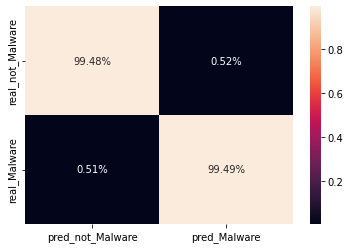

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

pred = clf.predict(x_adv_test)

y_true = y_adv_test

confusion = multilabel_confusion_matrix(y_true, pred)

print_confusion_matrix(confusion[0]/np.expand_dims(confusion[0].sum(axis=1),-1))

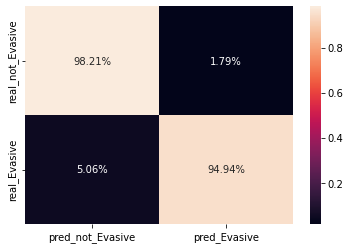

In [ ]:
print_confusion_matrix(confusion[1]/np.expand_dims(confusion[1].sum(axis=1),-1), label='Evasive')

In [ ]:
import pickle
filename = 'AdaBoost_MultiLabel_model.sav'
pickle.dump(clf, open(filename, 'wb'))

#TESTING AGAINST OTHER DATASETS

In [ ]:
university = pd.read_csv('/content/classifier_university_1.csv')
columns = ['size', 'count_page', 'title_len', 'count_image_total', 'count_obj', 'count_endobj',
           'count_stream', 'count_endstream', 'count_xref', 'count_trailer', 'count_startxref',
           'count_objstm', 'count_js', 'count_js_obs', 'count_javascript', 'count_javascript_obs',
           'count_action', 'count_action_obs', 'count_acroform', 'count_acroform_obs', 'class']

university = university[columns]
university.columns = non_evasive.columns[:-1]
university['pdfsize'] = university['pdfsize']/1000

In [ ]:
x= university.iloc[:,:-1]
y= university.iloc[:,-1]

In [ ]:
fpr = []
tpr = []
auc_list = []

In [ ]:
y.value_counts()

0    60631
1    50213
Name: class, dtype: int64

In [ ]:
len(y)

110844

###Baseline Model

0.9551351448883115 0.9903320905228474 0.9098440642861411 0.9483834137734185


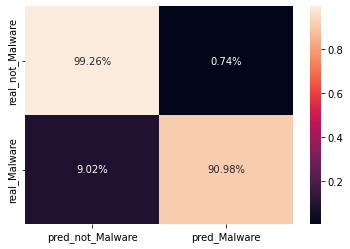

In [ ]:
get_metrics(non_evasive_model, x, y)

In [ ]:
from sklearn.metrics import roc_curve
y_true = y
x_norm = x.values
probs = non_evasive_model.predict_proba(x_norm)
fpr0, tpr0, thresholds0 = roc_curve(y, probs[:,1])

In [ ]:
from sklearn.metrics import auc

In [ ]:
fpr.append(fpr0)
tpr.append(tpr0)
auc_list.append(auc(fpr0, tpr0))

### Approach 1

0.9573454584821912 0.9857328976314047 0.919144444665724 0.9512748108910278


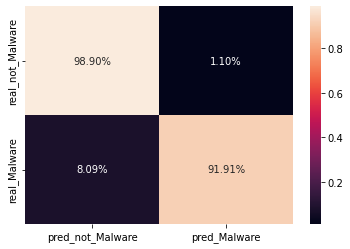

In [ ]:
get_metrics(adv_model, x, y)

In [ ]:
from sklearn.metrics import roc_curve
y_true = y
x_norm = x.values
probs = adv_model.predict_proba(x_norm)
fpr1, tpr1, thresholds1 = roc_curve(y, probs[:,1])

In [ ]:
fpr.append(fpr1)
tpr.append(tpr1)
auc_list.append(auc(fpr1, tpr1))

###Approach 2

0.9532315686911335 0.9848814420778326 0.9107402465496983 0.9463609461333113


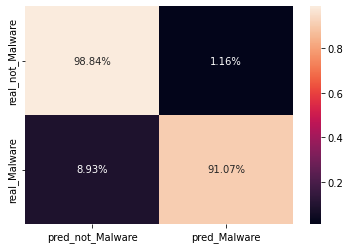

In [ ]:
pred = predict(x)

y_true = y

acc = accuracy_score(y_true, pred)
prec = precision_score(y_true, pred)
rec = recall_score(y_true, pred)
f1 = f1_score(y_true, pred)

print(acc, prec, rec, f1)
confusion = confusion_matrix(y_true, pred, normalize='true')
print_confusion_matrix(confusion)

In [ ]:
from sklearn.metrics import roc_curve, auc
y_true = y
probs = predict_proba(x)
fpr2, tpr2, thresholds2 = roc_curve(y, probs)

In [ ]:
fpr.append(fpr2)
tpr.append(tpr2)
auc_list.append(auc(fpr2, tpr2))

###Approach 3

0.9525549420807622 0.9860942906574395 0.908071614920439 0.9454760349600323


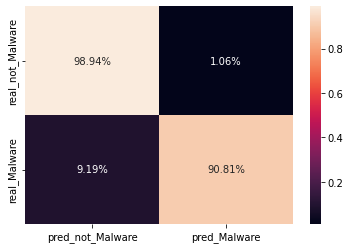

In [ ]:
pred = clf.predict(x)

y_true = y

acc = accuracy_score(y_true, pred[:,0])
prec = precision_score(y_true, pred[:,0])
rec = recall_score(y_true, pred[:,0])
f1 = f1_score(y_true, pred[:,0])

print(acc, prec, rec, f1)


confusion = confusion_matrix(y_true, pred[:,0], normalize='true')

print_confusion_matrix(confusion)

In [ ]:
from sklearn.metrics import roc_curve
y_true = y
x_norm = x.values
probs = clf.predict_proba(x_norm)
fpr3, tpr3, thresholds3 = roc_curve(y, probs[0][:,1])

In [ ]:
fpr.append(fpr3)
tpr.append(tpr3)
auc_list.append(auc(fpr3, tpr3))

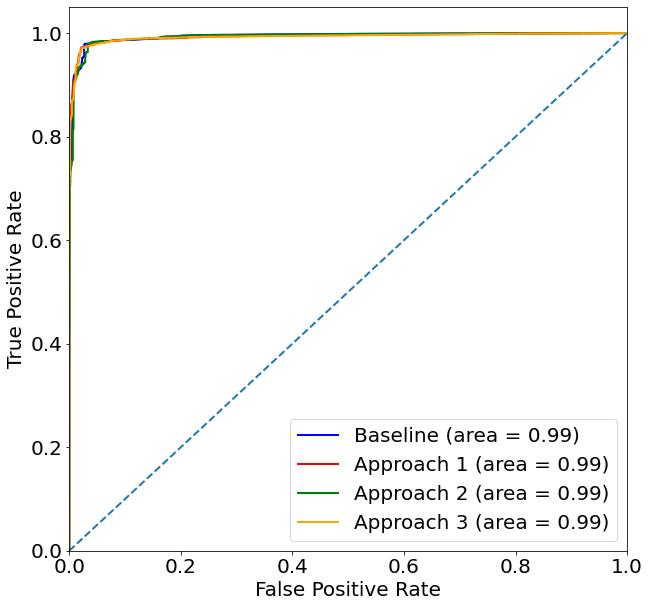

In [ ]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize = (10,10))
lw = 2
labels = ["Baseline", "Approach 1", "Approach 2", "Approach 3"]
colors = ["blue", "red", "green" , "orange"]
for i in range(4):
  plt.plot(
      fpr[i],
      tpr[i],
      lw=lw,
      color = colors[i],
      label= labels[i] + " (area = %0.2f)" % auc_list[i],
  )
plt.plot([0, 1], [0, 1], lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.title("Receiver operating characteristic for the baseline and the 3 approaches")
plt.legend(loc="lower right")
plt.show()

##TESTING AGAINST EVASION ATTACKS

##Generating Evasive Data

In [ ]:
evasive.drop(columns='Evasive', axis=0, inplace=True)

In [ ]:
y_true = evasive.iloc[:,-1]
x_ev = evasive.iloc[:,:-1]

pred=non_evasive_model.predict(x_ev)
acc = accuracy_score(y_true, pred)
prec = precision_score(y_true, pred)
rec = recall_score(y_true, pred)

print(acc, prec, rec)

0.6530235804377088 0.9800591651144954 0.5689117852827069


In [ ]:
wrong = np.abs(y_true.values-pred)
wrong

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
wrong.sum()

6960

In [ ]:
evasive['Real Evasive'] = wrong

In [ ]:
evasive['Real Evasive'].value_counts()

0    13099
1     6960
Name: Real Evasive, dtype: int64

In [ ]:
most_evasive = evasive[evasive['Real Evasive']==1]
len(most_evasive)

6960

In [ ]:
most_evasive.drop(columns="Real Evasive", inplace=True)

In [ ]:
most_evasive_malware = most_evasive[most_evasive['class']==1]
most_evasive_not_malware = most_evasive[most_evasive['class']==0]

In [ ]:
len(most_evasive_malware)

6778

In [ ]:
len(most_evasive_not_malware)

182

In [ ]:
!pip install sdv

In [ ]:
from sdv.tabular import TVAE
model = TVAE()
model.fit(most_evasive_malware)

In [ ]:
new_data_malware= model.sample(num_rows=450000,randomize_samples=False)
new_data_malware.head()

,pdfsize,pages,title characters,images,obj,endobj,stream,endstream,xref,trailer,...,ObjStm,JS,OBS_JS,Javascript,OBS_Javascript,OpenAction,OBS_OpenAction,Acroform,OBS_Acroform,class
0,644.326,70,0,1,348,351,128,128,1,1,...,0,1,0,1,0,1,0,1,0,1
1,648.050,68,0,1,348,345,124,124,1,1,...,0,1,0,1,0,0,0,1,0,1
2,696.506,68,0,1,353,353,128,125,1,1,...,0,1,0,1,0,0,0,1,0,1
3,715.926,68,0,0,759,667,250,192,1,1,...,0,1,0,1,0,1,0,1,0,1
4,707.102,70,10,2,388,373,141,138,1,1,...,0,1,0,1,0,1,0,1,0,1


In [ ]:
model2 = TVAE(epochs=500, decompress_dims=(256,256), compress_dims=(256,256), embedding_dim=256)
model2.fit(most_evasive_not_malware)

In [ ]:
new_data_not_malware= model2.sample(num_rows=50000,randomize_samples=False)
new_data_not_malware.head()

,pdfsize,pages,title characters,images,obj,endobj,stream,endstream,xref,trailer,...,ObjStm,JS,OBS_JS,Javascript,OBS_Javascript,OpenAction,OBS_OpenAction,Acroform,OBS_Acroform,class
0,44.0,1,0,0,9,8,2,2,1,1,...,0,0,0,0,0,0,0,2,0,0
1,84.0,1,0,1,10,6,2,2,1,1,...,0,0,0,0,0,0,0,2,0,0
2,55.0,1,1,1,5,10,2,2,1,1,...,0,0,0,0,0,0,0,2,0,0
3,47.0,1,0,1,11,10,2,4,1,1,...,0,0,0,0,0,0,0,2,0,0
4,35.0,1,0,1,9,6,2,3,1,1,...,0,0,0,0,0,0,0,2,0,0


In [ ]:
new_data = pd.concat([new_data_malware, new_data_not_malware], axis=0)

In [ ]:
len(new_data.drop_duplicates())

496515

In [ ]:
new_data.to_csv('Generated_Evasive_Samples.csv', index=False)

###Load Generated Data

In [ ]:
new_data = pd.read_csv('Generated_Evasive_Samples.csv')

In [ ]:
x = new_data.iloc[:,:-1]
y = new_data.iloc[:,-1]

In [ ]:
fpr_e = []
tpr_e = []
auc_e = []

####Baseline Model

0.096882 0.4906376487827142 0.09077777777777778 0.15320885348395433


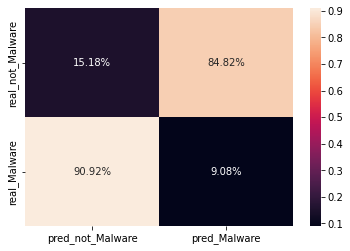

In [ ]:
plt.rcParams.update({'font.size': 10})
get_metrics(non_evasive_model, x, y)

In [ ]:
y_true = y
x_norm = x.values
probs = non_evasive_model.predict_proba(x_norm)
fpr0_e, tpr0_e, thresholds0_e = roc_curve(y, probs[:,1])

In [ ]:
fpr_e.append(fpr0_e)
tpr_e.append(tpr0_e)
auc_e.append(auc(fpr0_e, tpr0_e))

####Approach 1

0.923678 0.9903861037881656 0.9241688888888889 0.9561323948486802


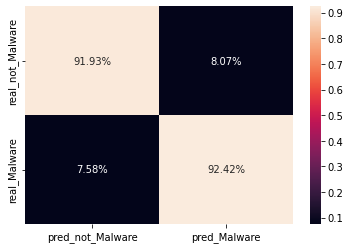

In [ ]:
get_metrics(adv_model, x, y)

In [ ]:
from sklearn.metrics import roc_curve
y_true = y
x_norm = x.values
probs = adv_model.predict_proba(x_norm)
fpr1_e, tpr1_e, thresholds1_e = roc_curve(y, probs[:,1])

In [ ]:
fpr_e.append(fpr1_e)
tpr_e.append(tpr1_e)
auc_e.append(auc(fpr1_e, tpr1_e))

####Approach 2

0.92355 0.9840823859962616 0.9301 0.9563300069117976


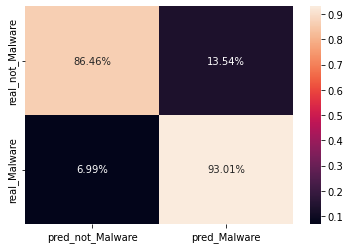

In [ ]:
pred = predict(x)

acc = accuracy_score(y, pred)
prec = precision_score(y, pred)
rec = recall_score(y, pred)
f1 = f1_score(y, pred)

print(acc, prec, rec, f1)

confusion = confusion_matrix(y, pred, normalize='true')
print_confusion_matrix(confusion)

In [ ]:
from sklearn.metrics import roc_curve, auc
y_true = y
probs = predict_proba(x)
fpr2_e, tpr2_e, thresholds2_e = roc_curve(y, probs)

In [ ]:
fpr_e.append(fpr2_e)
tpr_e.append(tpr2_e)
auc_e.append(auc(fpr2_e, tpr2_e))

####Approach 3

0.924894 0.9899223388156254 0.9259755555555556 0.9568817736422289


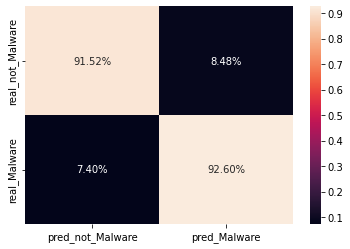

In [ ]:
pred = clf.predict(x)

acc = accuracy_score(y, pred[:,0])
prec = precision_score(y, pred[:,0])
rec = recall_score(y, pred[:,0])
f1 = f1_score(y, pred[:,0])

print(acc, prec, rec, f1)

confusion = confusion_matrix(y, pred[:,0], normalize='true')
print_confusion_matrix(confusion)

In [ ]:
from sklearn.metrics import roc_curve
y_true = y
x_norm = x.values
probs = clf.predict_proba(x_norm)
fpr3_e, tpr3_e, thresholds3 = roc_curve(y, probs[0][:,1])

In [ ]:
fpr_e.append(fpr3_e)
tpr_e.append(tpr3_e)
auc_e.append(auc(fpr3_e, tpr3_e))

In [ ]:
y = np.ones((500000,))
x_norm = x.values
pred = clf.predict(x_norm)
acc = accuracy_score(y, pred[:,1])
prec = precision_score(y, pred[:,1])
rec = recall_score(y, pred[:,1])
f1 = f1_score(y, pred[:,1])

print(acc, prec, rec)

confusion = confusion_matrix(y, pred[:,1])
confusion

0.942262 1.0 0.942262


array([[     0,      0],
       [ 28869, 471131]])

In [ ]:
y = np.ones((500000,))
x_norm = x.values
pred = evasive_model.predict(x_norm)
acc = accuracy_score(y, pred)
prec = precision_score(y, pred)
rec = recall_score(y, pred)
f1 = f1_score(y, pred)

print(acc, prec, rec)

confusion = confusion_matrix(y, pred)
confusion

0.882918 1.0 0.882918


array([[     0,      0],
       [ 58541, 441459]])

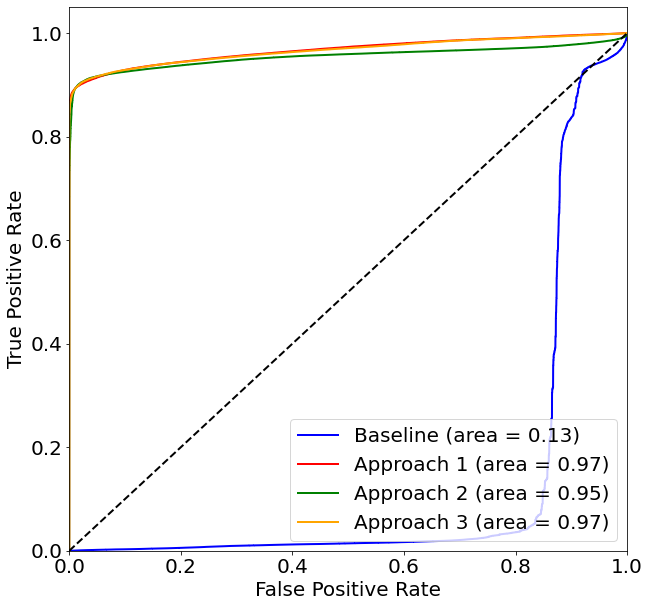

In [ ]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize = (10,10))
lw = 2
labels = ["Baseline", "Approach 1", "Approach 2", "Approach 3"]
colors = ["blue", "red", "green" , "orange"]
for i in range(4):
  plt.plot(
      fpr_e[i],
      tpr_e[i],
      lw=lw,
      color = colors[i],
      label= labels[i] + " (area = %0.2f)" % auc_e[i],
  )
plt.plot([0, 1], [0, 1], lw=lw, linestyle="--", color='black')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.title("Receiver operating characteristic for the baseline and the 3 approaches")
plt.legend(loc="lower right")

plt.show()